## GradCAM Implementation 
https://arxiv.org/pdf/1610.02391.pdf

In [1]:
import numpy as np
import keras 
from skimage.transform import resize
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from IPython.display import Image

Using TensorFlow backend.


In [112]:
# Using VGG16 Model

In [2]:
model = VGG16(weights="imagenet")

In [3]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

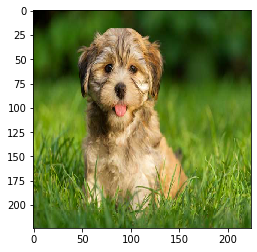

In [69]:
img_1_initial = load_img("cute-puppy-body-image.jpg", target_size=(224, 224))
plt.imshow(img_1_initial)
img_1 = img_to_array(img_1_initial)
img_1 = img_1.reshape((1, img_1.shape[0], img_1.shape[1], img_1.shape[2]))
img_1 = preprocess_input(img_1)


In [70]:
predict = model.predict(img_1)
decode_predictions(predict)

[[('n02094114', 'Norfolk_terrier', 0.39240992),
  ('n02096437', 'Dandie_Dinmont', 0.2504062),
  ('n02097474', 'Tibetan_terrier', 0.09021719),
  ('n02098105', 'soft-coated_wheaten_terrier', 0.04697506),
  ('n02095570', 'Lakeland_terrier', 0.043270625)]]

In [116]:
last_layer = model.get_layer('block5_conv3')

grads = keras.backend.gradients(model.output[:,512],last_layer.output)[0]
last_layer.output[0]

<tf.Tensor 'strided_slice_32:0' shape=(14, 14, 512) dtype=float32>

In [108]:
pooled_grads = keras.backend.mean(grads,axis=(0,1,2))
iterate = keras.backend.function([model.input],[pooled_grads,last_layer.output[0]])
pooled_grads_value,conv_layer_output = iterate([img_1])

In [109]:
for i in range(512):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)


In [ ]:
# Applying ReLU to the heatmap 
heatmap = np.maximum(heatmap,0)

In [110]:
# Upscaling
heatmap_resized = resize(heatmap, (224,224), preserve_range=True)

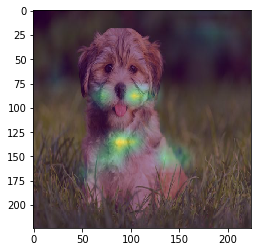

In [111]:
plt.imshow(heatmap_resized)
plt.imshow(img_1_initial, alpha=0.5)